In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import timm
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# 데이터셋 클래스 정의
class ImageDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = torch.tensor(data / 1023.0, dtype=torch.float32).view(-1, 1, 32, 32)  # 0~1023 -> 0~1 정규화
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.labels is None:
            return self.data[idx]
        return self.data[idx], self.labels[idx]

In [3]:
# EfficientNet 모델 정의
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=10):
        super(EfficientNetModel, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=num_classes)
        
        # 입력 채널 변경 (1채널)
        self.model.conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    
    def forward(self, x):
        return self.model(x)

In [4]:
# 데이터 불러오기
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
# 레이블 인코딩
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
train_features = train_df.drop(columns=['ID', 'label']).values
test_features = test_df.drop(columns=['ID']).values

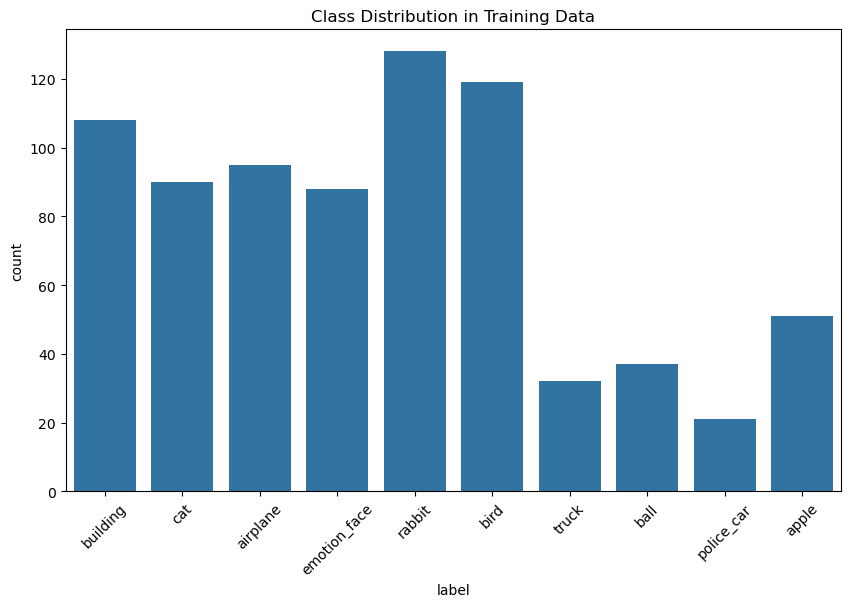

In [6]:
# 데이터 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x=train_df['label'])
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Data")
plt.show()

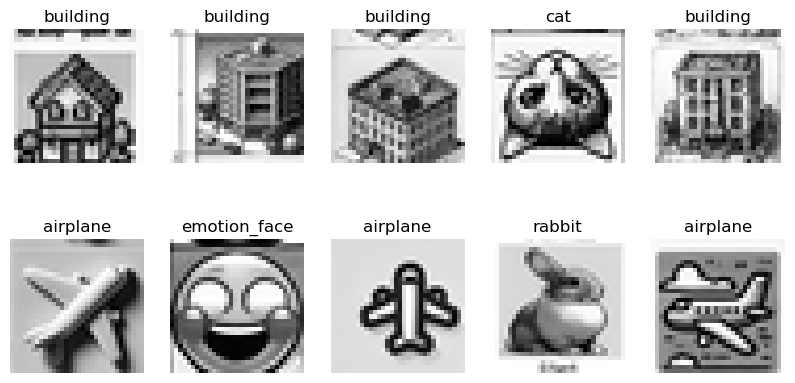

In [7]:
# 샘플 이미지 확인
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = train_features[i].reshape(32, 32)
    ax.imshow(img, cmap='gray')
    ax.set_title(label_encoder.inverse_transform([train_labels[i]])[0])
    ax.axis('off')
plt.show()

In [8]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# 데이터셋 및 데이터로더 생성
train_dataset = ImageDataset(X_train, y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(test_features)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

num_epochs = 15
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    
    # 검증 단계
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/15, Train Loss: 6.4718, Val Loss: 2.9711, Val Accuracy: 0.1558
Epoch 2/15, Train Loss: 5.0384, Val Loss: 2.4400, Val Accuracy: 0.1558
Epoch 3/15, Train Loss: 4.2272, Val Loss: 3.0484, Val Accuracy: 0.1558
Epoch 4/15, Train Loss: 3.2250, Val Loss: 2.6081, Val Accuracy: 0.2078
Epoch 5/15, Train Loss: 2.3929, Val Loss: 2.2178, Val Accuracy: 0.3052
Epoch 6/15, Train Loss: 1.8316, Val Loss: 2.4716, Val Accuracy: 0.2013
Epoch 7/15, Train Loss: 1.4954, Val Loss: 2.3402, Val Accuracy: 0.2403
Epoch 8/15, Train Loss: 1.4020, Val Loss: 2.3975, Val Accuracy: 0.3247
Epoch 9/15, Train Loss: 1.1170, Val Loss: 2.2541, Val Accuracy: 0.3377
Epoch 10/15, Train Loss: 0.8860, Val Loss: 2.9019, Val Accuracy: 0.3312
Epoch 11/15, Train Loss: 0.7683, Val Loss: 2.5607, Val Accuracy: 0.3701
Epoch 12/15, Train Loss: 0.6514, Val Loss: 2.4863, Val Accuracy: 0.3636
Epoch 13/15, Train Loss: 0.5768, Val Loss: 2.4722, Val Accuracy: 0.3766
Epoch 14/15, Train Loss: 0.5617, Val Loss: 2.5005, Val Accuracy: 0.3247
E

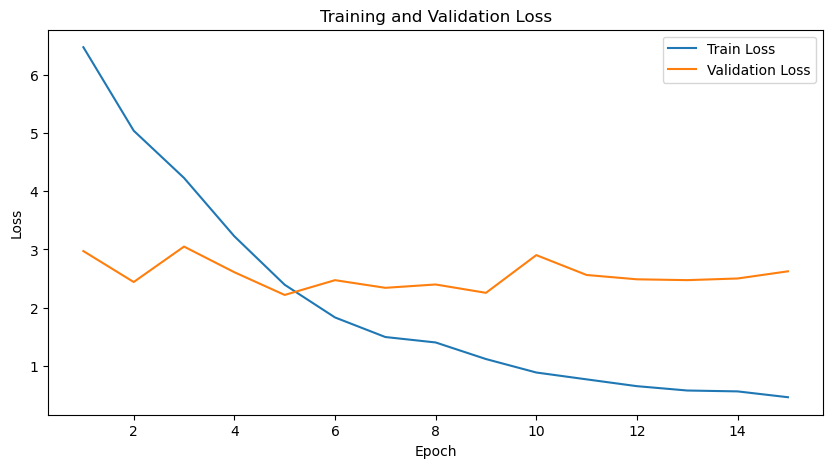

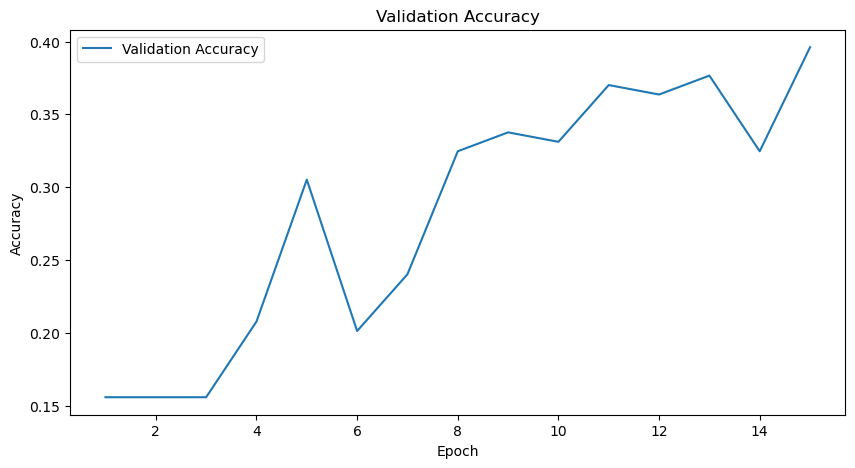

In [10]:
# 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [11]:
# 예측 및 저장
model.eval()
predictions = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)

In [12]:
# 결과 저장
submission = pd.DataFrame({"ID": test_df["ID"], "label": label_encoder.inverse_transform(predictions)})
submission.to_csv("submission.csv", index=False)